In [3]:
import os
import sys
import pandas as pd
import numpy as np
from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

import warnings
warnings.filterwarnings("ignore")

t0 = 1973
t1 = 2024
t0_str = str(t0+0.5)
t1_str = str(t1+0.5)

project_dir = '/dartfs-hpc/rc/lab/C/CMIG/damages/us_policy'
os.chdir(project_dir)


/dartfs-hpc/rc/home/0/f004260/.conda/envs/arg24/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# read in US transportation sector CO2 emissions from EIA
trans_emissions = pd.read_csv(os.path.join(project_dir,'data','raw','fair','MER_T11_05.csv'),skiprows=9)
trans_tot = trans_emissions.iloc[2:,[0,-1]] # get year and total
trans_tot.columns = ['year','co2_tot']
trans_tot['co2_tot'] = trans_tot['co2_tot'].astype(float)/1e3 # convert to Gt

In [5]:
# historical emissions of all species from FAiR
fair_emissions = pd.read_csv('data/raw/fair/extensions_1750-2500.csv').rename(columns={"scenario":"Scenario"})
fair_emissions_base = fair_emissions[fair_emissions['Scenario']=='medium-extension'] 
end = list(fair_emissions_base.columns).index('2024.5')
fair_emissions_base = fair_emissions_base.iloc[:,:end+1]

# solar and volcanic forcing from FAiR
fair_natural = pd.read_csv('data/raw/fair/volcanic_solar.csv')
fair_natural_base = fair_natural[fair_natural['Scenario']=='medium-extension']
fair_natural_base = fair_natural_base.iloc[:,:end+1]

# start w/ baseline scenario
emissions_out = [fair_emissions_base] 
natural_out = [fair_natural_base]

# remove all fossil fuel emissions during years of interest
no_ffi = fair_emissions_base.copy()
no_ffi.loc[no_ffi['variable']=='CO2 FFI',t0_str:t1_str] = 0
no_ffi.loc[no_ffi['variable']=='CH4',t0_str:t1_str] = 0
no_ffi['Scenario'] = 'no-ffi'
emissions_out.append(no_ffi)

# create copy of natural forcing w/ same scenario name 
natural_no_ffi = fair_natural_base.copy()
natural_no_ffi['Scenario'] = 'no-ffi'
natural_out.append(natural_no_ffi)



In [6]:
cp = fair_emissions_base.copy()
cp.loc[cp['variable']=='CO2 FFI',t0_str:t1_str] -= trans_tot['co2_tot'].values

cp['Scenario'] = 'no-us-transportation'
emissions_out.append(cp)

# always need to have the natural forcings w/ same scenario names
cp_nat = fair_natural_base.copy()
cp_nat['Scenario'] = 'no-us-transportation'
natural_out.append(cp_nat)

In [7]:
emissions_out = pd.concat(emissions_out)
natural_out = pd.concat(natural_out)
if not os.path.exists('data/interim/fair_scenarios'):
    os.makedirs('data/interim/fair_scenarios')
emissions_out.set_index("Scenario").to_csv(f'data/interim/fair_scenarios/transportation_emissions_scenarios_{t0}-{t1}.csv')
natural_out.set_index("Scenario").to_csv(f'data/interim/fair_scenarios/transportation_volcanic_solar_scenarios_{t0}-{t1}.csv')


In [8]:
f = FAIR(ch4_method="Thornhill2021")
f.define_time(1750, t1, 1)  # start, end, step

emissions_file = f"data/interim/fair_scenarios/transportation_emissions_scenarios_{t0}-{t1}.csv"
forcing_file = f"data/interim/fair_scenarios/transportation_volcanic_solar_scenarios_{t0}-{t1}.csv"

# define scenarios
emissions = pd.read_csv(emissions_file)
scenarios = list(emissions['Scenario'].unique())
f.define_scenarios(scenarios)

fair_params_1_4_1_file = 'data/raw/fair/calibrated_constrained_parameters_calibration1.4.1.csv'
df_configs = pd.read_csv(fair_params_1_4_1_file, index_col=0)
configs = df_configs.index  # this is used as a label for the "config" axis
f.define_configs(configs)

fair_species_configs_1_4_1_file = 'data/raw/fair/species_configs_properties_calibration1.4.1.csv'
species, properties = read_properties(filename=fair_species_configs_1_4_1_file)
f.define_species(species, properties)

f.allocate()

f.fill_from_csv(
    emissions_file=emissions_file,
    forcing_file=forcing_file,
)

fill(
    f.forcing,
    f.forcing.sel(specie="Volcanic") * df_configs["forcing_scale[Volcanic]"].values.squeeze(),
    specie="Volcanic",
)
fill(
    f.forcing,
    f.forcing.sel(specie="Solar") * df_configs["forcing_scale[Solar]"].values.squeeze(),
    specie="Solar",
)

f.fill_species_configs(fair_species_configs_1_4_1_file)
f.override_defaults(fair_params_1_4_1_file)

initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)

# run simulations!
f.run()

# save temperature output
gmst = f.temperature.sel(layer=0)
gmst = gmst-gmst.sel(timebounds=slice(1850,1900)).mean("timebounds") # normalize to 1850-1900 baseline
gmst = gmst.rename({"timebounds":"year"}).sel(year=slice(t0,t1))
gmst.attrs = {"units":"$^{\circ}C$","description":"GMST anomaly relative to 1850-1900, from FAiR calibration ensemble v1.4.1"}
gmst.name = 'gmst'
if not os.path.exists('data/interim/fair_outputs'):
    os.makedirs('data/interim/fair_outputs')
if os.path.exists(f"data/interim/fair_outputs/fair_gmst_transportation_scenarios_{t0}-{t1}.nc"):
    os.remove(f"data/interim/fair_outputs/fair_gmst_transportation_scenarios_{t0}-{t1}.nc")
gmst.to_netcdf(f"data/interim/fair_outputs/fair_gmst_transportation_scenarios_{t0}-{t1}.nc")


Running 2523 projections in parallel: 100%|██████████| 274/274 [00:05<00:00, 49.74timesteps/s]


In [9]:
gmst

<xarray.DataArray 'gmst' (year: 52, scenario: 3, config: 841)> Size: 1MB
array([[[ 0.29154701,  0.2910866 ,  0.24999544, ...,  0.22103085,
          0.40740349,  0.27250645],
        [ 0.29154701,  0.2910866 ,  0.24999544, ...,  0.22103085,
          0.40740349,  0.27250645],
        [ 0.29154701,  0.2910866 ,  0.24999544, ...,  0.22103085,
          0.40740349,  0.27250645]],

       [[ 0.37615416,  0.2174705 ,  0.23675131, ...,  0.39222874,
          0.38059662,  0.19266654],
        [ 0.3725396 ,  0.20731444,  0.22478354, ...,  0.37934461,
          0.36324453,  0.17601355],
        [ 0.37606388,  0.21724257,  0.23641399, ...,  0.39185869,
          0.38020158,  0.19220883]],

       [[ 0.40338659,  0.15120438,  0.26191162, ...,  0.3221747 ,
          0.49739582, -0.09979224],
        [ 0.3910276 ,  0.12248752,  0.2315154 , ...,  0.29185741,
          0.45710591, -0.13632532],
        [ 0.40308678,  0.15058721,  0.2610899 , ...,  0.32134161,
          0.4965237 , -0.10074697]],
...
       [[ 1.33884958,  1.23034354,  1.38993197, ...,  1.11709937,
          1.15323217,  1.32335865],
        [ 0.58041866,  0.33697119,  0.22472439, ...,  0.37344917,
          0.23325677,  0.24749698],
        [ 1.31682846,  1.20445501,  1.35030369, ...,  1.09173175,
          1.1272704 ,  1.28803631]],

       [[ 1.196133  ,  1.22340058,  1.35575341, ...,  1.18027096,
          1.25944502,  1.19371411],
        [ 0.42183624,  0.31079409,  0.16499094, ...,  0.42081104,
          0.32113143,  0.09303715],
        [ 1.17370248,  1.19695076,  1.31528103, ...,  1.15440977,
          1.23299586,  1.15757454]],

       [[ 1.1818622 ,  1.16411664,  1.2691269 , ...,  1.08574981,
          1.1720291 ,  1.26253817],
        [ 0.39178667,  0.23274915,  0.05300609, ...,  0.31069533,
          0.21575317,  0.13735724],
        [ 1.1590232 ,  1.13709603,  1.22780515, ...,  1.05938657,
          1.14508522,  1.22558422]]])
Coordinates:
  * year      (year) float64 416B 1.973e+03 1.974e+03 ... 2.023e+03 2.024e+03
  * scenario  (scenario) <U20 240B 'medium-extension' ... 'no-us-transportation'
  * config    (config) int64 7kB 1234 2451 5859 5883 ... 1592589 1594247 1597937
    layer     int64 8B 0
Attributes:
    units:        $^{\circ}C$
    description:  GMST anomaly relative to 1850-1900, from FAiR calibration e...

In [10]:
gmst['scenario'].values

array(['medium-extension', 'no-ffi', 'no-us-transportation'], dtype='<U20')

In [11]:

del_gmst = (gmst.sel(scenario='medium-extension')-gmst.sel(scenario='no-us-transportation'))
years = np.arange(t0,t1+1)

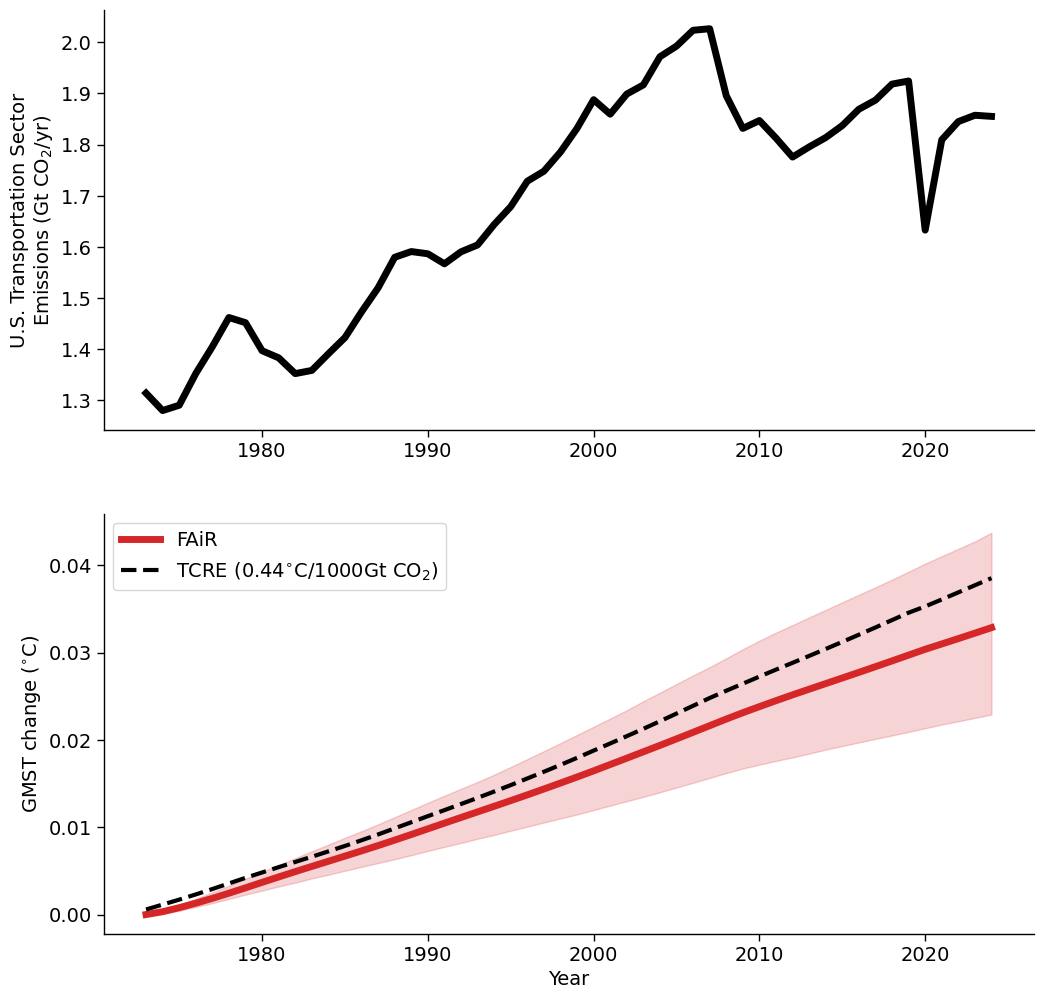

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import rcParams

# rcParams["font.family"] = "sans-serif"
# rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 14.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams["mathtext.default"] = "regular"

fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(nrows=2,ncols=1,figure=fig)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],sharex=ax1)

ax1.plot(years,trans_tot['co2_tot'],color='black',lw=5)
ax1.set_ylabel("U.S. Transportation Sector\nEmissions (Gt $CO_2$/yr)") 
ax2.plot(years,del_gmst.mean("config").values,color='tab:red',lw=5,label='FAiR')
ax2.fill_between(years,del_gmst.quantile(0.025,'config').values,del_gmst.quantile(0.975,'config').values,color='tab:red',alpha=0.2)
ax2.set_ylabel("GMST change ($^{\circ}C$)")
ax2.set_xlabel("Year")
ax2.plot(years,trans_tot['co2_tot'].cumsum()*.44/1000,color='black',lw=3,linestyle='--',label='TCRE (0.44$^{\circ}C$/1000Gt $CO_2$)')
ax2.legend(loc='upper left')

ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)

plt.savefig("figures/transportation_emissions_dgmst.pdf",dpi=350)

In [13]:
# taken from table s16
dmg_coefs = np.array([0.146,0.283,-0.0547]) ## in numpy polyfit format -- quadratic, then linear, then intercept
dmg_sd = np.array([0.017,0.11,0.134])
nboot = 100
np.random.seed(100)
dmg_coef0 = np.random.normal(loc=dmg_coefs[2],scale=dmg_sd[2],size=nboot)
dmg_coef1 = np.random.normal(loc=dmg_coefs[1],scale=dmg_sd[1],size=nboot)
dmg_coef2 = np.random.normal(loc=dmg_coefs[0],scale=dmg_sd[0],size=nboot)

[np.float64(0.12388578256603582), np.float64(0.5867879403329298)]
[np.float64(0.6897498218863121), np.float64(1.4356434615761573)]


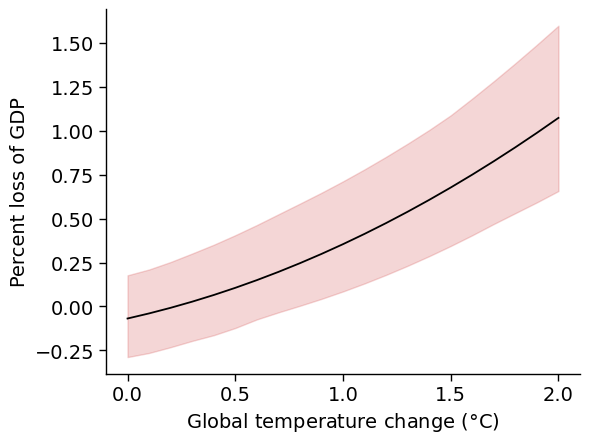

In [14]:
fig = plt.figure(figsize=(6,4.5))

gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.11,right=0.9,top=0.92,bottom=0.11,wspace=0.2,hspace=0.2)

ax = plt.subplot(gs0[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

t_x = np.arange(0,2+0.1,0.1)
dmgs = np.zeros((nboot,len(t_x)))
for n in np.arange(0,nboot,1):
    dmgs[n,:] = dmg_coef0[n] + dmg_coef1[n]*t_x + (dmg_coef2[n]*(t_x**2))
ax.fill_between(t_x,np.percentile(dmgs,2.5,axis=0),np.percentile(dmgs,97.5,axis=0),
                color=[0.8,0.2,0.2],alpha=0.2)
plt.plot(t_x,np.mean(dmgs,axis=0),color="black",linewidth=1.3)
#y = hsiang_coefs[2] + (t_x*hsiang_coefs[1]) + ((t_x**2)*hsiang_coefs[0])

print([np.percentile(dmgs[:,t_x==1],5),np.percentile(dmgs[:,t_x==1],95)])
print([np.percentile(dmgs[:,t_x==2],5),np.percentile(dmgs[:,t_x==2],95)])

plt.xlabel(r"Global temperature change ($\degree$C)")
plt.ylabel("Percent loss of GDP")

plt.show()

In [15]:
import xarray as xr
n_config = len(gmst.config.values)
configs = gmst.config.values
yrs = gmst.year.values
scenarios = gmst.scenario.values
fair_damages = xr.DataArray(np.zeros((nboot,len(yrs),3,n_config)),
                            coords=[np.arange(0,nboot,1),yrs,scenarios,configs],
                            dims=["dmg_uncertainty","year","scenario","config"])
for n in np.arange(0,nboot,1):
    fair_damages[n,:,:,:] = dmg_coef0[n] + (gmst*dmg_coef1[n]) + ((gmst**2)*dmg_coef2[n])

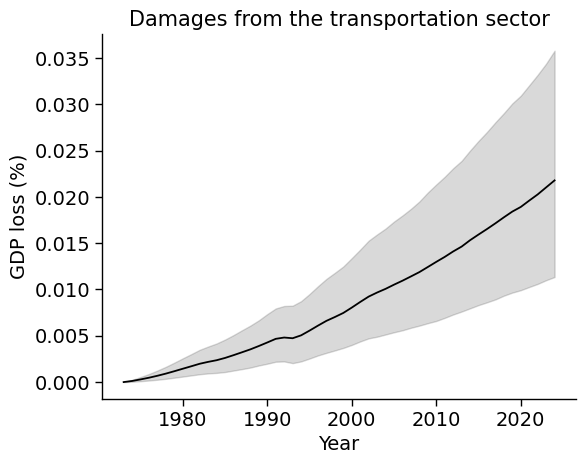

In [49]:
fig = plt.figure(figsize=(6,4.5))

gs0 = gridspec.GridSpec(1,1)
gs0.update(left=0.11,right=0.9,top=0.92,bottom=0.11,wspace=0.2,hspace=0.2)

ax = plt.subplot(gs0[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

tfs = 15

transportation_sector_damages = fair_damages.sel(scenario="medium-extension") - fair_damages.sel(scenario="no-us-transportation")
yrs = transportation_sector_damages.year.values
ax.fill_between(yrs,transportation_sector_damages.quantile(q=0.025,dim=["config","dmg_uncertainty"]).values,
                transportation_sector_damages.quantile(q=0.975,dim=["config","dmg_uncertainty"]).values,
                color="black",alpha=0.15)
plt.plot(yrs,transportation_sector_damages.mean(dim=["config","dmg_uncertainty"]).values,color="black",linewidth=1.3)

plt.title("Damages from the transportation sector",fontsize=tfs)
plt.ylabel("GDP loss (%)")
plt.xlabel("Year")
plt.savefig("figures/transportation_sector_damages_pctgdp.png",bbox_inches='tight',dpi=350)
plt.savefig("figures/transportation_sector_damages_pctgdp.pdf",bbox_inches='tight',dpi=350)
plt.show()

In [48]:
dmg_pct = transportation_sector_damages.quantile([0.025,0.5,0.975],dim=['dmg_uncertainty','config'])
dmg_pct.name = 'pct_gdp'
dmg_pct_df = dmg_pct.to_dataframe()
dmg_pct_df = dmg_pct_df.reset_index().pivot(index='year',columns='quantile',values='pct_gdp')
dmg_pct_df.to_csv('data/damages/transportation_sector_damages_pctgdp.csv')

In [17]:
yrs_damages = np.arange(1973,2024+1,1)
gdp = pd.read_csv(os.path.join(project_dir,'data','raw',"API_NY.GDP.MKTP.KD_DS2_en_csv_v2_2557.csv"))
us_gdp = gdp.loc[gdp["Country Code"]=="USA",:].iloc[:,4:].values[0]
us_gdp_xr = xr.DataArray(us_gdp,coords=[np.arange(1960,2024+1,1)],dims=["year"])
transportation_sector_dmg_dollar = (transportation_sector_damages/100.0)*us_gdp_xr.loc[yrs_damages] ## divide by 100 bc "1 percent" should be 0.01

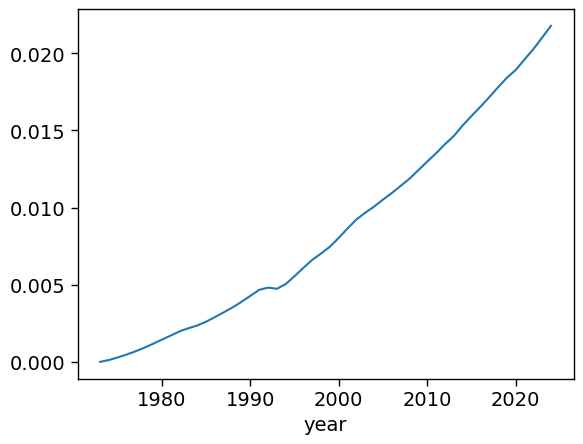

In [36]:
transportation_sector_damages.mean(['dmg_uncertainty','config']).plot()

In [27]:
transportation_sector_dmg_dollar

<xarray.DataArray (dmg_uncertainty: 100, year: 52, config: 841)> Size: 35MB
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.13673669e+06,  2.20152116e+06,  3.37790888e+06, ...,
          4.76836914e+06,  5.00546350e+06,  4.21020980e+06],
        [ 3.91721328e+06,  5.19275369e+06,  8.58930664e+06, ...,
          9.63351681e+06,  1.29017482e+07,  3.61236330e+06],
        ...,
        [ 2.41064362e+09,  2.64238531e+09,  4.45038342e+09, ...,
          2.39712534e+09,  2.51562283e+09,  3.81430648e+09],
        [ 2.30530361e+09,  2.76445566e+09,  4.57986080e+09, ...,
          2.62654462e+09,  2.83012620e+09,  3.69114415e+09],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.36721406e+06,  2.89331334e+06,  4.38201824e+06, ...,
          5.69517784e+06,  6.00884376e+06,  5.63404742e+06],
        [ 4.65639078e+06,  7.18642614e+06,  1.09682759e+07, ...,
          1.18932294e+07,  1.48042146e+07,  7.42331988e+06],
...
        [ 2.45455931e+09,  2.74582507e+09,  4.49905092e+09, ...,
          2.55042217e+09,  2.65565061e+09,  3.89892081e+09],
        [ 2.41109871e+09,  2.87675210e+09,  4.65710971e+09, ...,
          2.75699602e+09,  2.92464479e+09,  3.86784741e+09],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.03355776e+06,  7.02115309e+06,  1.05051478e+07, ...,
          1.25383686e+07,  1.33041758e+07,  1.38982427e+07],
        [ 1.01966197e+07,  1.82509810e+07,  2.58985946e+07, ...,
          2.71396989e+07,  3.10989445e+07,  2.40158368e+07],
        ...,
        [ 4.02481224e+09,  4.54883724e+09,  7.35001785e+09, ...,
          4.27403709e+09,  4.43363110e+09,  6.40587381e+09],
        [ 4.00710946e+09,  4.76909062e+09,  7.63120621e+09, ...,
          4.59007398e+09,  4.83169221e+09,  6.43411712e+09],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]]])
Coordinates:
  * dmg_uncertainty  (dmg_uncertainty) int64 800B 0 1 2 3 4 5 ... 95 96 97 98 99
  * year             (year) float64 416B 1.973e+03 1.974e+03 ... 2.024e+03
  * config           (config) int64 7kB 1234 2451 5859 ... 1594247 1597937

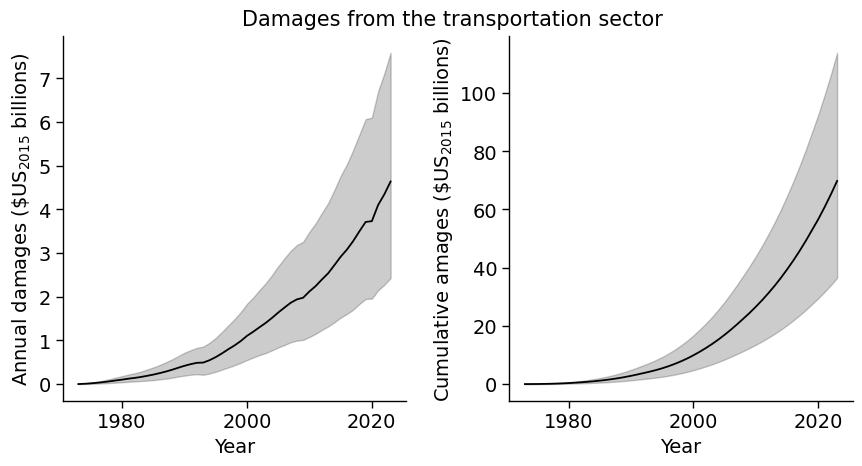

In [18]:
fig = plt.figure(figsize=(10,4.5))


gs0 = gridspec.GridSpec(1,2)
gs0.update(left=0.11,right=0.9,top=0.92,bottom=0.11,wspace=0.3,hspace=0.2)

ax = plt.subplot(gs0[0,0])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

tfs = 15

transportation_sector_damages_plot = transportation_sector_dmg_dollar/1e9
yrs = transportation_sector_damages_plot.year.values
ax.fill_between(yrs,transportation_sector_damages_plot.quantile(q=0.025,dim=["config","dmg_uncertainty"]).values,
                transportation_sector_damages_plot.quantile(q=0.975,dim=["config","dmg_uncertainty"]).values,
                color="black",alpha=0.2)
ax.plot(yrs,transportation_sector_damages_plot.mean(dim=["config","dmg_uncertainty"]).values,color="black",linewidth=1.3)

ax2 = plt.subplot(gs0[0,1])
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.fill_between(yrs[:-1],transportation_sector_damages_plot.cumsum("year").quantile(q=0.025,dim=["config","dmg_uncertainty"]).values[:-1],
                transportation_sector_damages_plot.cumsum("year").quantile(q=0.975,dim=["config","dmg_uncertainty"]).values[:-1],
                color="black",alpha=0.2)
ax2.plot(yrs[:-1],transportation_sector_damages_plot.cumsum("year").mean(dim=["config","dmg_uncertainty"]).values[:-1],color="black",linewidth=1.3)

fig.suptitle("Damages from the transportation sector",fontsize=tfs)
ax.set_ylabel(r"Annual damages (\$US$_{2015}$ billions)")
ax.set_xlabel("Year")

ax2.set_ylabel(r"Cumulative amages (\$US$_{2015}$ billions)")
ax2.set_xlabel("Year")

plt.savefig("figures/transportation_sector_damages.pdf")
plt.savefig("figures/transportation_sector_damages.png",bbox_inches='tight',dpi=350)
plt.show()

In [19]:
transportation_sector_damages_cs = transportation_sector_damages_plot.isel(year=slice(0,-1)).cumsum("year")
transportation_sector_damages_cs.name = 'cumulative damages'
transportation_sector_damages_plot.name = 'annual damages'

In [20]:
ann_dmg_df = transportation_sector_damages_plot.quantile([0.025,0.5,0.975],dim=['config','dmg_uncertainty']).to_dataframe().dropna()
ann_dmg_df = ann_dmg_df.reset_index().pivot(index='year',columns='quantile',values='annual damages')

In [21]:
ann_dmg_df.to_csv('data/damages/annual_damages_transport.csv')

In [39]:
trans

65

In [40]:
len(ann_dmg_df[0.5])

51

In [22]:
cum_dmg_df = transportation_sector_damages_cs.quantile([0.025,0.5,0.975],dim=['config','dmg_uncertainty']).to_dataframe().dropna()
cum_dmg_df = cum_dmg_df.reset_index().pivot(index='year',columns='quantile',values='cumulative damages')

In [24]:
cum_dmg_df.to_csv('data/damages/cumulative_damages_transport.csv')

In [25]:
cum_dmg_df

quantile      0.025      0.500       0.975
year                                      
1973.0     0.000000   0.000000    0.000000
1974.0     0.001942   0.006664    0.013935
1975.0     0.007803   0.023045    0.045890
1976.0     0.018687   0.051468    0.099796
1977.0     0.035813   0.094674    0.180258
1978.0     0.061129   0.155883    0.292445
1979.0     0.096011   0.236780    0.439439
1980.0     0.139691   0.335899    0.619171
1981.0     0.194598   0.456596    0.835402
1982.0     0.256813   0.593498    1.080098
1983.0     0.329417   0.752143    1.362250
1984.0     0.412606   0.936522    1.691445
1985.0     0.508715   1.148365    2.070501
1986.0     0.620061   1.391955    2.503055
1987.0     0.749904   1.671496    2.996167
1988.0     0.902403   1.991492    3.556917
1989.0     1.080425   2.358643    4.192630
1990.0     1.283030   2.767129    4.904497
1991.0     1.506873   3.213350    5.677229
1992.0     1.742102   3.689588    6.497842
1993.0     1.967671   4.169523    7.344487
1994.0     2.220466   4.703999    8.280464
1995.0     2.516055   5.308657    9.326745
1996.0     2.861022   5.999602   10.508360
1997.0     3.255251   6.777869   11.836494
1998.0     3.696531   7.641873   13.309492
1999.0     4.204323   8.606204   14.936492
2000.0     4.772577   9.687668   16.762143
2001.0     5.398543  10.867534   18.737944
2002.0     6.075826  12.139118   20.858098
2003.0     6.806388  13.509489   23.150263
2004.0     7.594852  14.991566   25.630412
2005.0     8.461533  16.583211   28.296452
2006.0     9.386982  18.288483   31.147095
2007.0    10.359138  20.103548   34.170303
2008.0    11.368670  22.002025   37.338769
2009.0    12.414045  23.934660   40.539279
2010.0    13.512365  26.007623   43.978235
2011.0    14.694736  28.200150   47.598538
2012.0    15.947743  30.540687   51.494721
2013.0    17.284154  33.017464   55.576380
2014.0    18.719539  35.671524   59.950479
2015.0    20.259955  38.517331   64.725837
2016.0    21.914097  41.522626   69.662485
2017.0    23.646206  44.717653   74.975728
2018.0    25.513322  48.116918   80.609073
2019.0    27.511763  51.722944   86.619666
2020.0    29.513346  55.336133   92.671568
2021.0    31.710163  59.319488   99.311268
2022.0    33.992606  63.551496  106.289550
2023.0    36.491131  68.036243  113.851699